In [8]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns

import statistics

import joblib

In [9]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1


In [10]:
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [11]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new

In [12]:
def plot_cm(cm_val, save=False, which="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(which, fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    # if save is not False:
    #     save_path = '{}_{}.png'.format(split)
    #     plt.savefig(save_path)
    #     print("Save fig at {}".format(save_path))
    plt.show()

In [13]:
def false_predict(y_true, y_pred):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3/"
    test_path =  "{}/test.csv".format(path)
    test_data = pd.read_csv(test_path)
    false_indices = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            false_indices.append(i)
    print(test_data.loc[false_indices])
    return false_indices


In [14]:
def evaluate(param,split):
    loaded_model = joblib.load('SVM_model/SVM_{}.joblib'.format(split))
    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    # print(y_pred_val_raw[:])
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    # print(y_pred_val[:])
    # print(y_val[:])
    false = false_predict(y_val,y_pred_val)
    print(false[:])
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, "Validate set")
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test, "Test set")

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    return cm_val,cm_test,auc1,auc2

In [15]:
def evaluate_no_prob(param,split):
    loaded_model = joblib.load('SVM_model-ROC/SVM_{}.joblib'.format(split))
    ############## validate set ################
    print("############## validate set ################")
    y_pred_val = loaded_model.predict(x_val)
    print
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

    # plot confusion matrix
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()
    
    # calculate roc curves
    fpr, tpr, thresholds = metrics.roc_curve(y_true,  y_prob[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test = loaded_model.predict(x_test)
    # Print the predictions
    # print(y_pred)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    sen_test = sensitivity(cm_test)
    spec_test = specificity(cm_test)
    acc_test = accuracy(cm_test)
    pre_test = precision(cm_test)
    f1_score_test = f1(cm_test)

    # plot confusion matrix
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_test.shape[1]),
           yticks=np.arange(cm_norm_test.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Test set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_test.max() / 2.
    for i in range(cm_norm_test.shape[0]):
        for j in range(cm_norm_test.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_test[i, j] > thresh else "black",
                   fontsize=20)

    plt.show()

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    return cm_val,cm_test,auc1,auc2


In [73]:
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

In [17]:
# def train(split):
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     svm = SVC(C=10, gamma=0.01, kernel='rbf')
#     lr = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')
#     dt = DecisionTreeClassifier(criterion="entropy", max_depth=31, min_samples_leaf=1, min_samples_split=3, splitter="random")
#     sgd = SGDClassifier(loss='hinge', penalty='elasticnet', learning_rate='optimal', eta0=0.001, max_iter=1000, alpha=0.01)
#     rf = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=130)
#     ensemble = VotingClassifier(estimators=[('svm', svm), ('lr', lr), ('dt', dt), ('sgd', sgd), ('rf', rf)], voting='hard')
#     ensemble.fit(x_train, y_train)
#     joblib.dump(ensemble, 'ensemble_model_Final/ensemble_{}.joblib'.format(split))

In [18]:
# train("split1")
# train("split2")
# train("split3")
# train("split4")
# train("split5")

# Grid Search

In [74]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

# Define parameter grid
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Define SGD model
model = SVC()

# Define grid search object
grid_search = GridSearchCV(model, param_grid)

# Fit grid search object to the data
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
# loss = grid_search.best_params_['loss']
# penalty = grid_search.best_params_['penalty']
# learning_rate = grid_search.best_params_['learning_rate']
# eta0 = grid_search.best_params_['eta0']
# max_iter = grid_search.best_params_['max_iter']
# alpha = grid_search.best_params_['alpha']

../kitt/DATA_progress3//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


# grid search split1-5

In [20]:
# split1 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
# split2 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
# split3 {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
# split4 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
# split5 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [21]:
def SVM_train_param1(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    svm = SVC(C=10, gamma=0.1, kernel='rbf',probability=True)
    svm.fit(x_train, y_train)
    joblib.dump(svm, 'SVM_model/SVM_{}.joblib'.format(split))

In [22]:
def SVM_train_param2(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    svm = SVC(C=100, gamma=0.01, kernel='rbf',probability=True)
    svm.fit(x_train, y_train)
    joblib.dump(svm, 'SVM_model/SVM_{}.joblib'.format(split))

In [23]:
def SVM_train_param3(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    svm = SVC(C=1000, gamma=0.01, kernel='rbf',probability=True)
    svm.fit(x_train, y_train)
    joblib.dump(svm, 'SVM_model/SVM_{}.joblib'.format(split))

In [24]:
def SVM_train_param4(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    svm = SVC(C=10, gamma=0.1, kernel='rbf',probability=True)
    svm.fit(x_train, y_train)
    joblib.dump(svm, 'SVM_model/SVM_{}.joblib'.format(split))

In [25]:
def SVM_train_param5(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    svm = SVC(C=10, gamma=0.1, kernel='rbf',probability=True)
    svm.fit(x_train, y_train)
    joblib.dump(svm, 'SVM_model/SVM_{}.joblib'.format(split))

In [26]:
SVM_train_param1("split1")
SVM_train_param2("split2")
SVM_train_param3("split3")
SVM_train_param4("split4")
SVM_train_param5("split5")

../kitt/DATA_progress3//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
../kitt/DATA_progress3//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
../kitt/DATA_progress3//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
../kitt/DATA_progress3//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
../kitt/DATA_progress3//split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_p

# Setting Split 1

In [27]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split1

############## validate set ################
Best Threshold=0.126190
FPR: 0.0175
TPR: 1.0000
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
56  8711216         B         19.46      880.2          0.07445   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
56          0.0515         0.1844                 0.05268        2.06   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
56    46.61       0.003443       0.03056       0.0152              0.001519   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
56           0.08774           0.1882          0.2527                  0.05972  
[56]
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


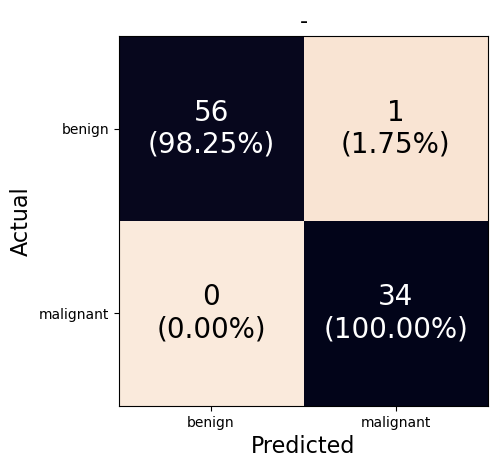

################# test set ##################
Best Threshold=0.454706
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split1
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


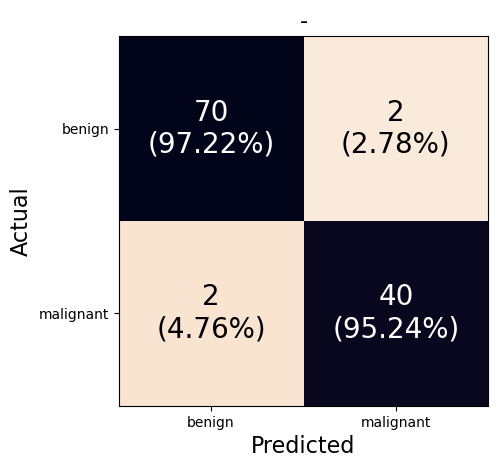

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


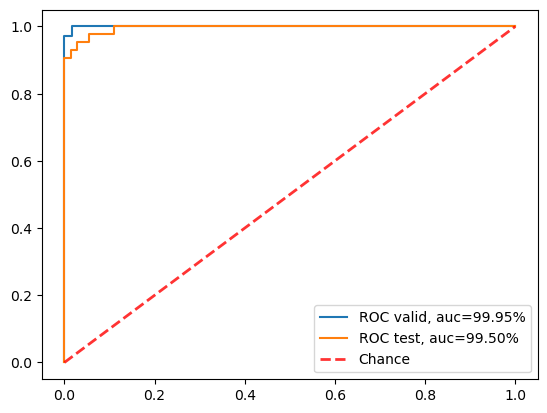

In [28]:
param = 1
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

## param2 split1

############## validate set ################
Best Threshold=0.126190
FPR: 0.0175
TPR: 1.0000
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
56  8711216         B         19.46      880.2          0.07445   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
56          0.0515         0.1844                 0.05268        2.06   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
56    46.61       0.003443       0.03056       0.0152              0.001519   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
56           0.08774           0.1882          0.2527                  0.05972  
[56]
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


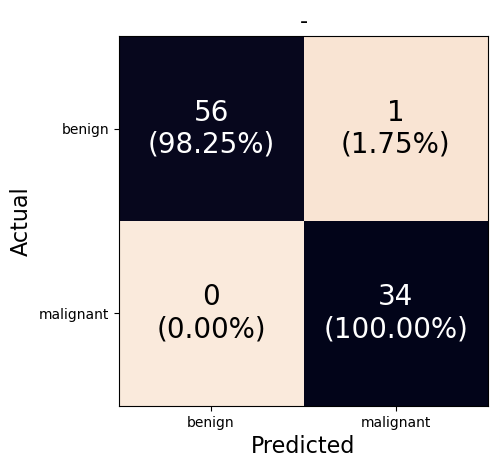

################# test set ##################
Best Threshold=0.454706
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split1
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


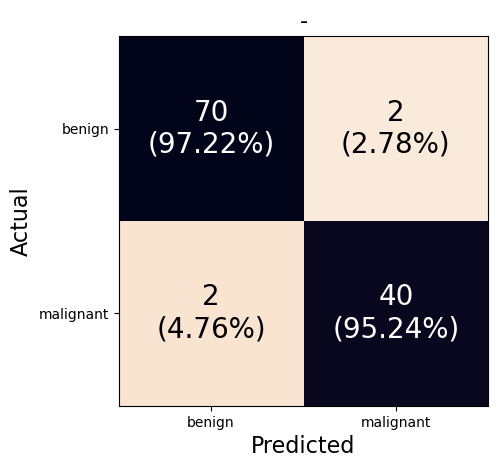

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


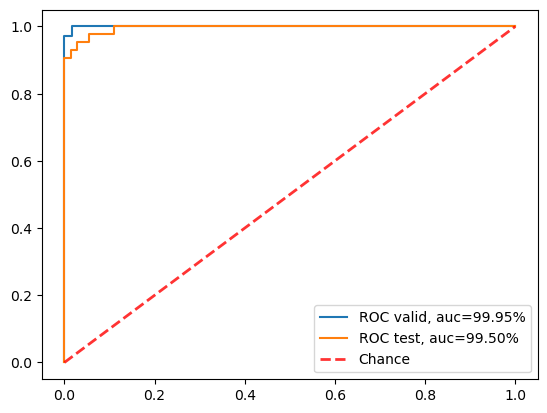

In [29]:
param = 2
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

## param3 split1

############## validate set ################
Best Threshold=0.126190
FPR: 0.0175
TPR: 1.0000
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
56  8711216         B         19.46      880.2          0.07445   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
56          0.0515         0.1844                 0.05268        2.06   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
56    46.61       0.003443       0.03056       0.0152              0.001519   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
56           0.08774           0.1882          0.2527                  0.05972  
[56]
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


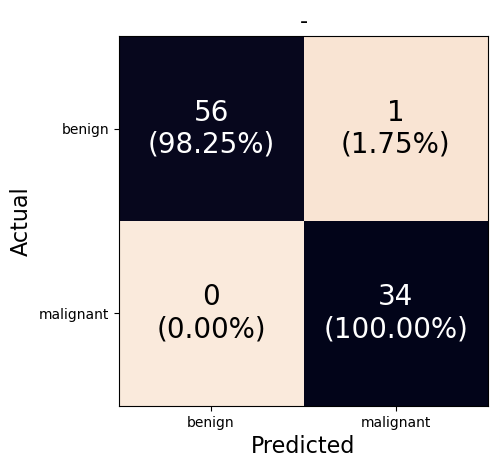

################# test set ##################
Best Threshold=0.454706
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split1
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


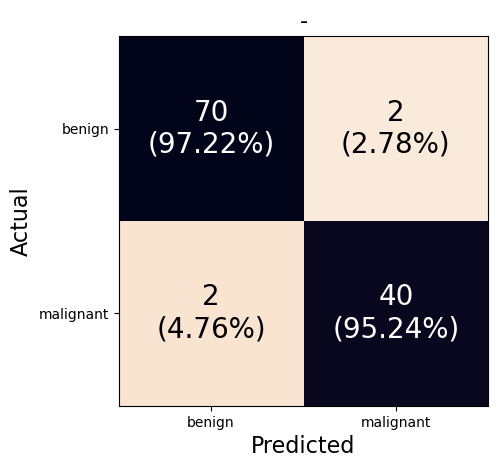

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


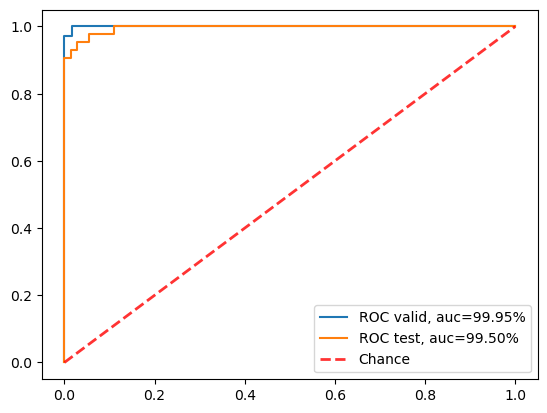

In [30]:
param = 3
param3_split1_cm_val, param3_split1_cm_test, param3_split1_AUC_val, param3_split1_AUC_test = evaluate(param,split)

## param4 split1

############## validate set ################
Best Threshold=0.126190
FPR: 0.0175
TPR: 1.0000
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
56  8711216         B         19.46      880.2          0.07445   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
56          0.0515         0.1844                 0.05268        2.06   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
56    46.61       0.003443       0.03056       0.0152              0.001519   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
56           0.08774           0.1882          0.2527                  0.05972  
[56]
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


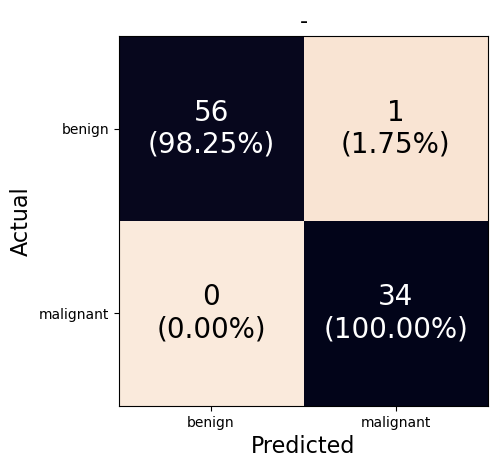

################# test set ##################
Best Threshold=0.454706
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split1
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


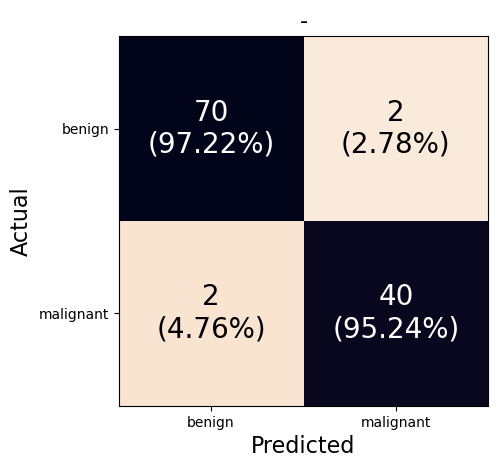

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


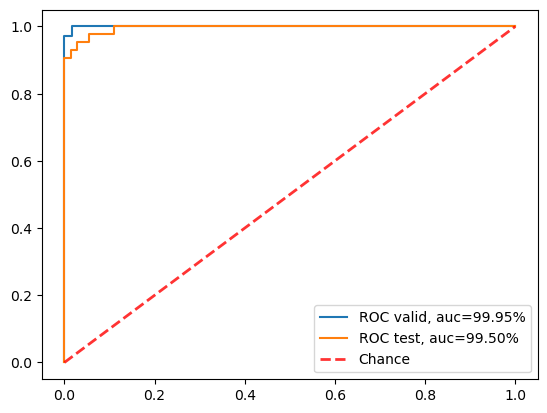

In [31]:
param = 4
param4_split1_cm_val, param4_split1_cm_test, param4_split1_AUC_val, param4_split1_AUC_test = evaluate(param,split)

## param5 split1

############## validate set ################
Best Threshold=0.126190
FPR: 0.0175
TPR: 1.0000
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
56  8711216         B         19.46      880.2          0.07445   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
56          0.0515         0.1844                 0.05268        2.06   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
56    46.61       0.003443       0.03056       0.0152              0.001519   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
56           0.08774           0.1882          0.2527                  0.05972  
[56]
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


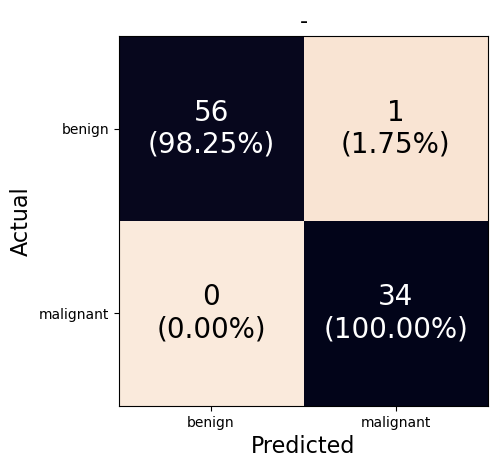

################# test set ##################
Best Threshold=0.454706
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split1
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


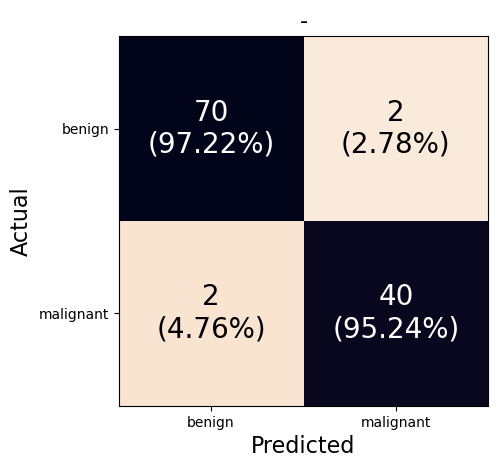

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


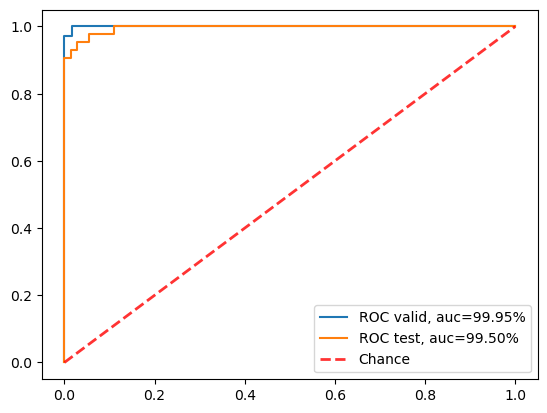

In [32]:
param = 5
param5_split1_cm_val, param5_split1_cm_test, param5_split1_AUC_val, param5_split1_AUC_test = evaluate(param,split)

# Setting Split 2

In [33]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split2

############## validate set ################
Best Threshold=0.517128
FPR: 0.0000
TPR: 0.9412
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
57  8810528         B         18.94      428.0          0.08871   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
57         0.02669         0.1533                 0.06057      0.8652   
79         0.11530         0.1692                 0.05727      1.2020   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
57    17.12       0.005517       0.02045      0.01616              0.002922   
79    68.35       0.006001       0.02855      0.01492              0.002205   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
57            0.1280           0.1471          0.2535                  0.07993  
79            0.1465           0.3965          0.3109                  0.07610  
[57,

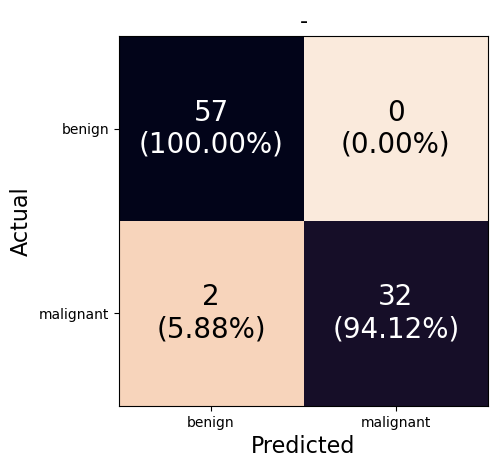

################# test set ##################
Best Threshold=0.350098
FPR: 0.0139
TPR: 0.9286
Confusion Matrix
----------------
[[71  1]
 [ 3 39]] 

----------------
split2
Sensitivity: 92.86%
Specificity: 98.61%
Accuracy: 96.49%
Precision: 97.50%
Sensitivity: 92.86%
Precision: 97.50%
F1: 95.12%


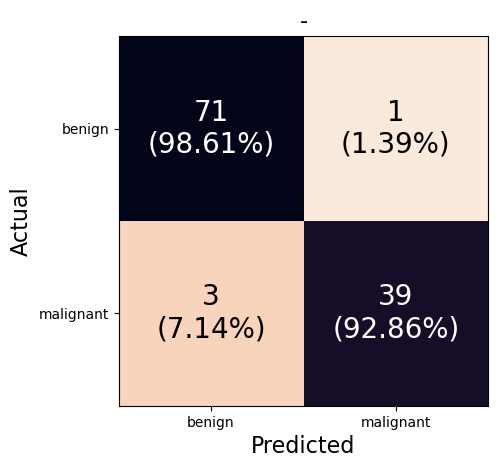

---------------------------------------
AUC validate: 97.42%
AUC test: 97.88%


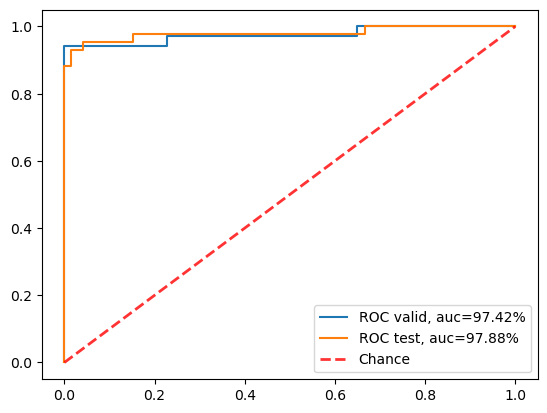

In [34]:
param = 1
param1_split2_cm_val, param1_split2_cm_test, param1_split2_AUC_val, param1_split2_AUC_test = evaluate(param,split)

## param2 split2

############## validate set ################
Best Threshold=0.517128
FPR: 0.0000
TPR: 0.9412
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
57  8810528         B         18.94      428.0          0.08871   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
57         0.02669         0.1533                 0.06057      0.8652   
79         0.11530         0.1692                 0.05727      1.2020   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
57    17.12       0.005517       0.02045      0.01616              0.002922   
79    68.35       0.006001       0.02855      0.01492              0.002205   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
57            0.1280           0.1471          0.2535                  0.07993  
79            0.1465           0.3965          0.3109                  0.07610  
[57,

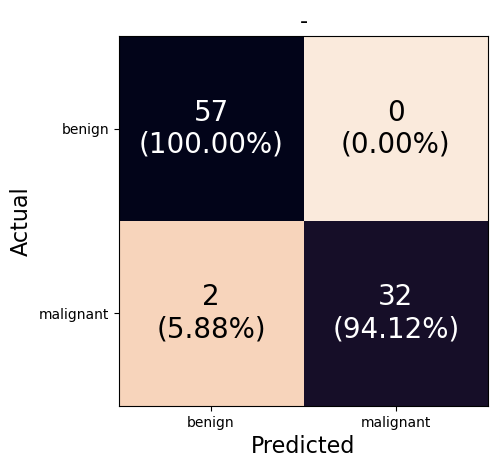

################# test set ##################
Best Threshold=0.350098
FPR: 0.0139
TPR: 0.9286
Confusion Matrix
----------------
[[71  1]
 [ 3 39]] 

----------------
split2
Sensitivity: 92.86%
Specificity: 98.61%
Accuracy: 96.49%
Precision: 97.50%
Sensitivity: 92.86%
Precision: 97.50%
F1: 95.12%


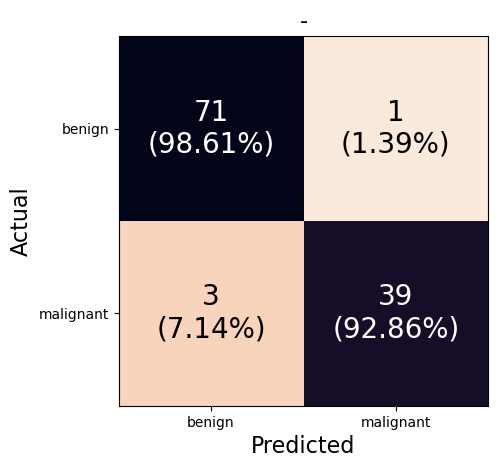

---------------------------------------
AUC validate: 97.42%
AUC test: 97.88%


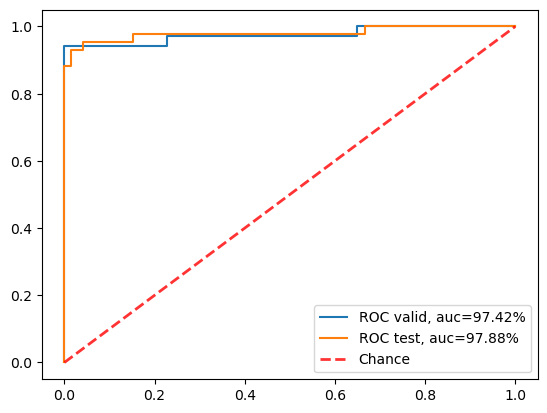

In [35]:
param = 2
param2_split2_cm_val, param2_split2_cm_test, param2_split2_AUC_val, param2_split2_AUC_test = evaluate(param,split)

## param3 split2

############## validate set ################
Best Threshold=0.517128
FPR: 0.0000
TPR: 0.9412
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
57  8810528         B         18.94      428.0          0.08871   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
57         0.02669         0.1533                 0.06057      0.8652   
79         0.11530         0.1692                 0.05727      1.2020   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
57    17.12       0.005517       0.02045      0.01616              0.002922   
79    68.35       0.006001       0.02855      0.01492              0.002205   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
57            0.1280           0.1471          0.2535                  0.07993  
79            0.1465           0.3965          0.3109                  0.07610  
[57,

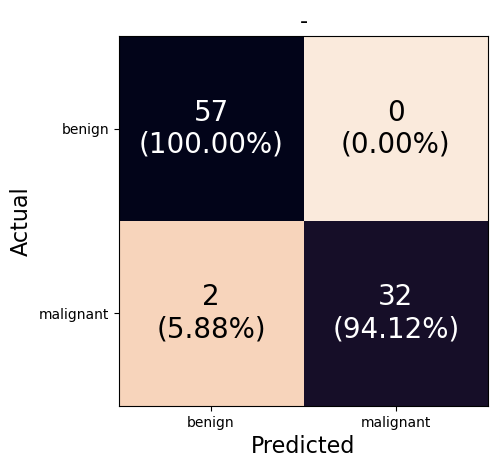

################# test set ##################
Best Threshold=0.350098
FPR: 0.0139
TPR: 0.9286
Confusion Matrix
----------------
[[71  1]
 [ 3 39]] 

----------------
split2
Sensitivity: 92.86%
Specificity: 98.61%
Accuracy: 96.49%
Precision: 97.50%
Sensitivity: 92.86%
Precision: 97.50%
F1: 95.12%


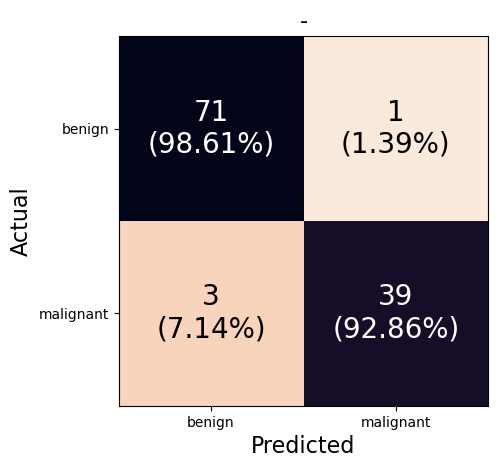

---------------------------------------
AUC validate: 97.42%
AUC test: 97.88%


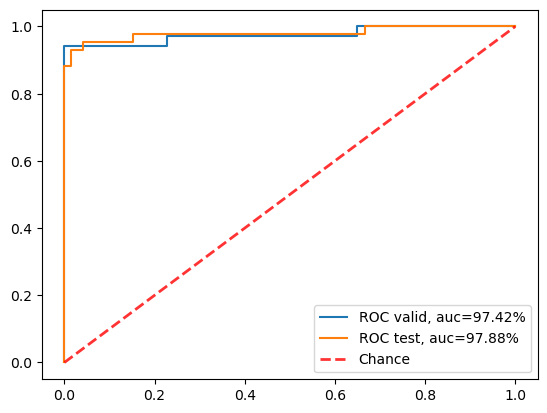

In [36]:
param = 3
param3_split2_cm_val, param3_split2_cm_test, param3_split2_AUC_val, param3_split2_AUC_test = evaluate(param,split)

## param4 split2

############## validate set ################
Best Threshold=0.517128
FPR: 0.0000
TPR: 0.9412
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
57  8810528         B         18.94      428.0          0.08871   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
57         0.02669         0.1533                 0.06057      0.8652   
79         0.11530         0.1692                 0.05727      1.2020   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
57    17.12       0.005517       0.02045      0.01616              0.002922   
79    68.35       0.006001       0.02855      0.01492              0.002205   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
57            0.1280           0.1471          0.2535                  0.07993  
79            0.1465           0.3965          0.3109                  0.07610  
[57,

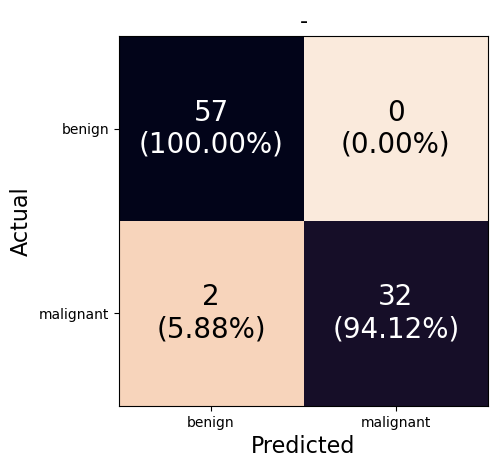

################# test set ##################
Best Threshold=0.350098
FPR: 0.0139
TPR: 0.9286
Confusion Matrix
----------------
[[71  1]
 [ 3 39]] 

----------------
split2
Sensitivity: 92.86%
Specificity: 98.61%
Accuracy: 96.49%
Precision: 97.50%
Sensitivity: 92.86%
Precision: 97.50%
F1: 95.12%


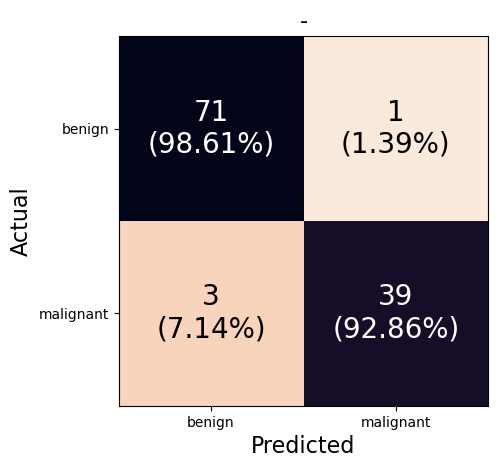

---------------------------------------
AUC validate: 97.42%
AUC test: 97.88%


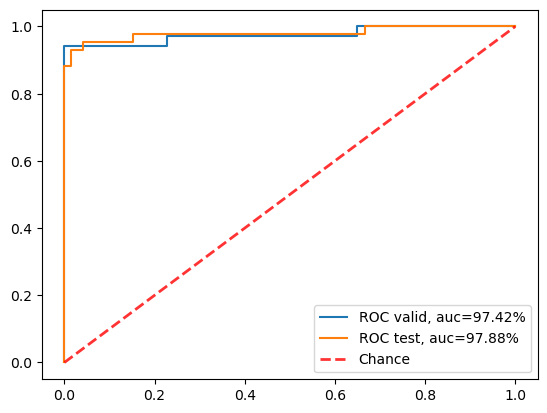

In [37]:
param = 4
param4_split2_cm_val, param4_split2_cm_test, param4_split2_AUC_val, param4_split2_AUC_test = evaluate(param,split)

## param5 split2

############## validate set ################
Best Threshold=0.517128
FPR: 0.0000
TPR: 0.9412
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
57  8810528         B         18.94      428.0          0.08871   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
57         0.02669         0.1533                 0.06057      0.8652   
79         0.11530         0.1692                 0.05727      1.2020   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
57    17.12       0.005517       0.02045      0.01616              0.002922   
79    68.35       0.006001       0.02855      0.01492              0.002205   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
57            0.1280           0.1471          0.2535                  0.07993  
79            0.1465           0.3965          0.3109                  0.07610  
[57,

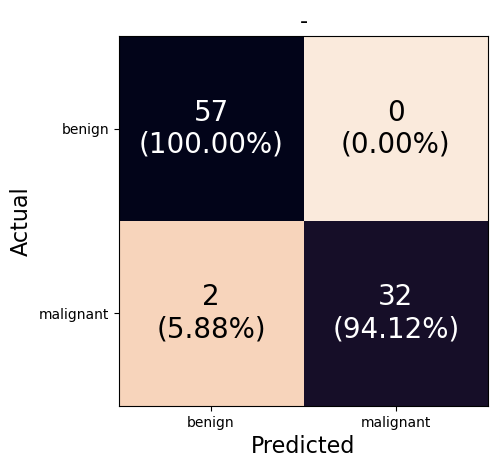

################# test set ##################
Best Threshold=0.350098
FPR: 0.0139
TPR: 0.9286
Confusion Matrix
----------------
[[71  1]
 [ 3 39]] 

----------------
split2
Sensitivity: 92.86%
Specificity: 98.61%
Accuracy: 96.49%
Precision: 97.50%
Sensitivity: 92.86%
Precision: 97.50%
F1: 95.12%


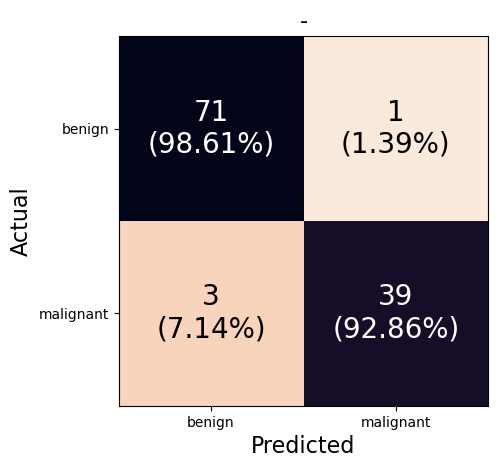

---------------------------------------
AUC validate: 97.42%
AUC test: 97.88%


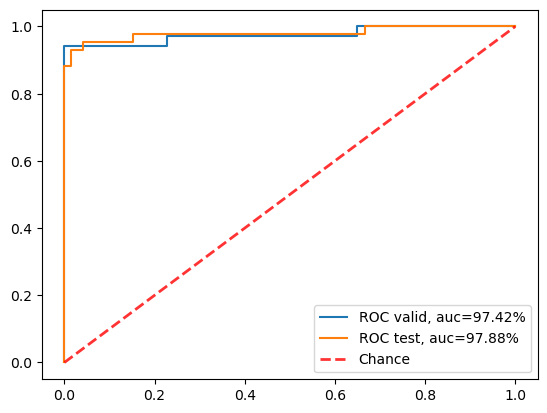

In [38]:
param = 5
param5_split2_cm_val, param5_split2_cm_test, param5_split2_AUC_val, param5_split2_AUC_test = evaluate(param,split)

# Setting Split 3

In [39]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split3

############## validate set ################
Best Threshold=0.591462
FPR: 0.0351
TPR: 0.9412
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
28  903011         B         15.50      392.0          0.08365   
55  903554         B         17.72      446.2          0.10290   
81  846381         M         23.95      782.7          0.08401   
87  925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
28         0.10070         0.1810                 0.07252       1.067   
55         0.04783         0.1937                 0.06161       1.652   
81         0.09938         0.1847                 0.05338       1.078   
87         0.25500         0.2128                 0.07152       1.205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
28    22.97       0.010380       0.09472      0.01219              0.012330   
55    22.22       0.008146       0.01843      0.0201

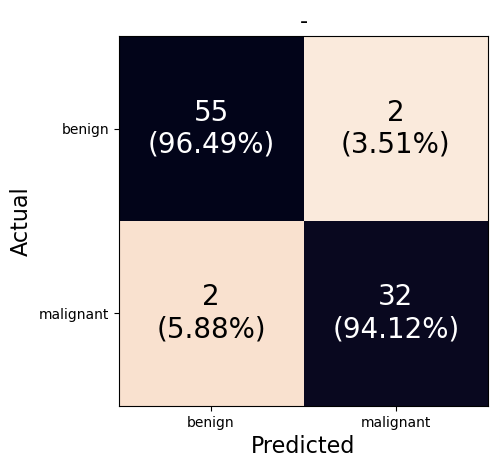

################# test set ##################
Best Threshold=0.557077
FPR: 0.0694
TPR: 0.9048
Confusion Matrix
----------------
[[67  5]
 [ 4 38]] 

----------------
split3
Sensitivity: 90.48%
Specificity: 93.06%
Accuracy: 92.11%
Precision: 88.37%
Sensitivity: 90.48%
Precision: 88.37%
F1: 89.41%


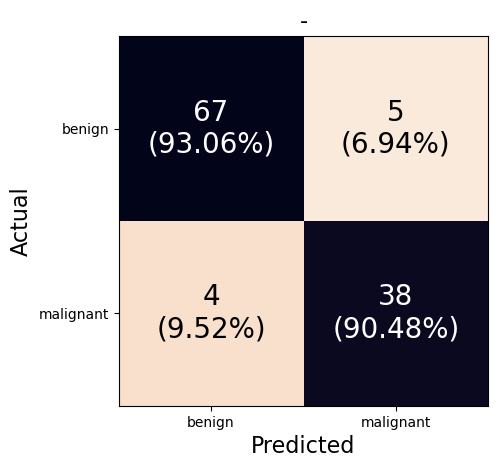

---------------------------------------
AUC validate: 97.06%
AUC test: 96.96%


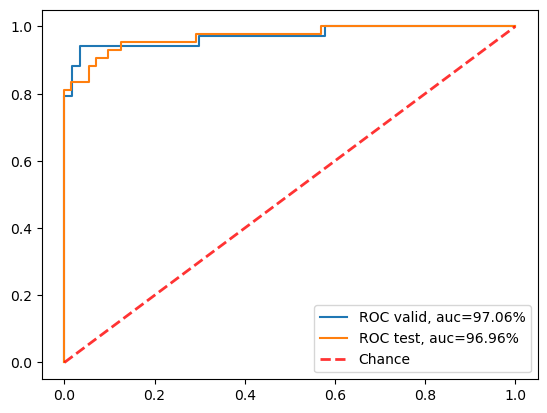

In [40]:
param = 1
param1_split3_cm_val, param1_split3_cm_test, param1_split3_AUC_val, param1_split3_AUC_test = evaluate(param,split)

## param2 split3

############## validate set ################
Best Threshold=0.591462
FPR: 0.0351
TPR: 0.9412
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
28  903011         B         15.50      392.0          0.08365   
55  903554         B         17.72      446.2          0.10290   
81  846381         M         23.95      782.7          0.08401   
87  925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
28         0.10070         0.1810                 0.07252       1.067   
55         0.04783         0.1937                 0.06161       1.652   
81         0.09938         0.1847                 0.05338       1.078   
87         0.25500         0.2128                 0.07152       1.205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
28    22.97       0.010380       0.09472      0.01219              0.012330   
55    22.22       0.008146       0.01843      0.0201

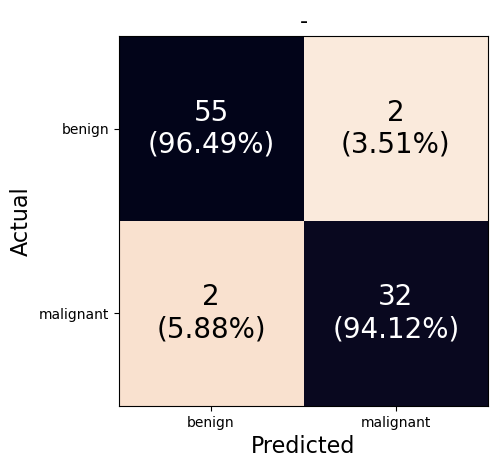

################# test set ##################
Best Threshold=0.557077
FPR: 0.0694
TPR: 0.9048
Confusion Matrix
----------------
[[67  5]
 [ 4 38]] 

----------------
split3
Sensitivity: 90.48%
Specificity: 93.06%
Accuracy: 92.11%
Precision: 88.37%
Sensitivity: 90.48%
Precision: 88.37%
F1: 89.41%


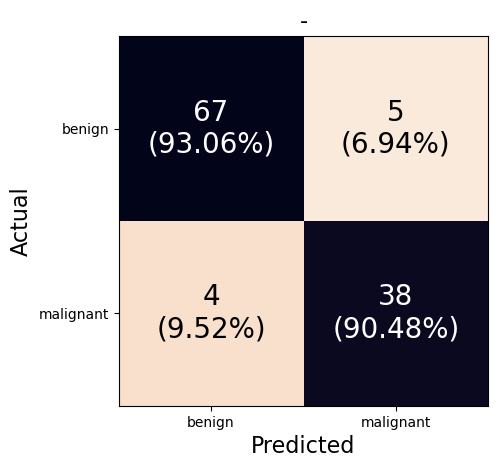

---------------------------------------
AUC validate: 97.06%
AUC test: 96.96%


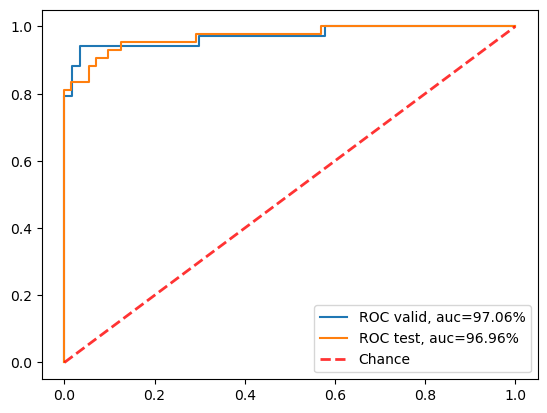

In [41]:
param = 2
param2_split3_cm_val, param2_split3_cm_test, param2_split3_AUC_val, param2_split3_AUC_test = evaluate(param,split)

## param3 split3

############## validate set ################
Best Threshold=0.591462
FPR: 0.0351
TPR: 0.9412
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
28  903011         B         15.50      392.0          0.08365   
55  903554         B         17.72      446.2          0.10290   
81  846381         M         23.95      782.7          0.08401   
87  925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
28         0.10070         0.1810                 0.07252       1.067   
55         0.04783         0.1937                 0.06161       1.652   
81         0.09938         0.1847                 0.05338       1.078   
87         0.25500         0.2128                 0.07152       1.205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
28    22.97       0.010380       0.09472      0.01219              0.012330   
55    22.22       0.008146       0.01843      0.0201

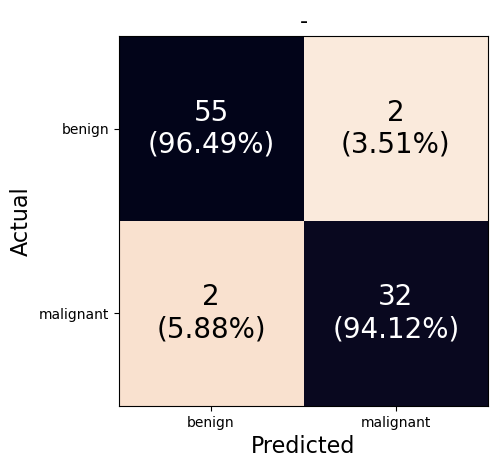

################# test set ##################
Best Threshold=0.557077
FPR: 0.0694
TPR: 0.9048
Confusion Matrix
----------------
[[67  5]
 [ 4 38]] 

----------------
split3
Sensitivity: 90.48%
Specificity: 93.06%
Accuracy: 92.11%
Precision: 88.37%
Sensitivity: 90.48%
Precision: 88.37%
F1: 89.41%


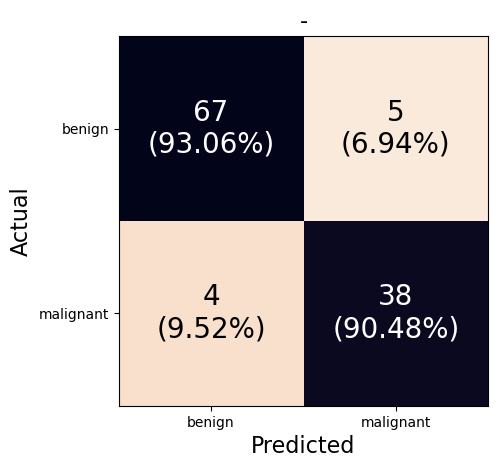

---------------------------------------
AUC validate: 97.06%
AUC test: 96.96%


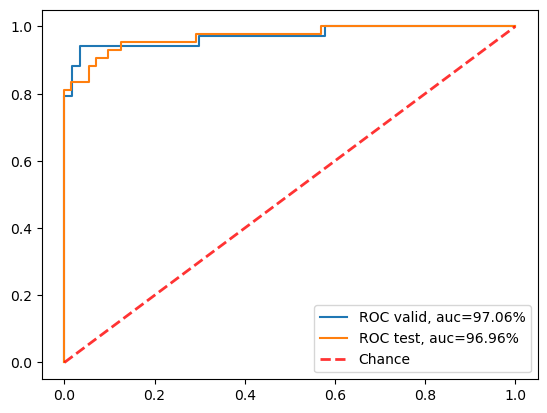

In [42]:
param = 3
param3_split3_cm_val, param3_split3_cm_test, param3_split3_AUC_val, param3_split3_AUC_test = evaluate(param,split)

## param4 split3

############## validate set ################
Best Threshold=0.591462
FPR: 0.0351
TPR: 0.9412
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
28  903011         B         15.50      392.0          0.08365   
55  903554         B         17.72      446.2          0.10290   
81  846381         M         23.95      782.7          0.08401   
87  925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
28         0.10070         0.1810                 0.07252       1.067   
55         0.04783         0.1937                 0.06161       1.652   
81         0.09938         0.1847                 0.05338       1.078   
87         0.25500         0.2128                 0.07152       1.205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
28    22.97       0.010380       0.09472      0.01219              0.012330   
55    22.22       0.008146       0.01843      0.0201

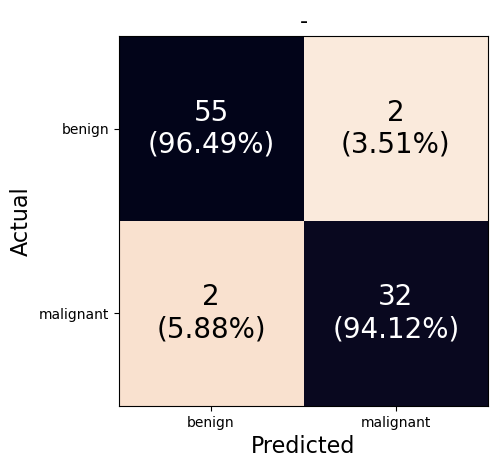

################# test set ##################
Best Threshold=0.557077
FPR: 0.0694
TPR: 0.9048
Confusion Matrix
----------------
[[67  5]
 [ 4 38]] 

----------------
split3
Sensitivity: 90.48%
Specificity: 93.06%
Accuracy: 92.11%
Precision: 88.37%
Sensitivity: 90.48%
Precision: 88.37%
F1: 89.41%


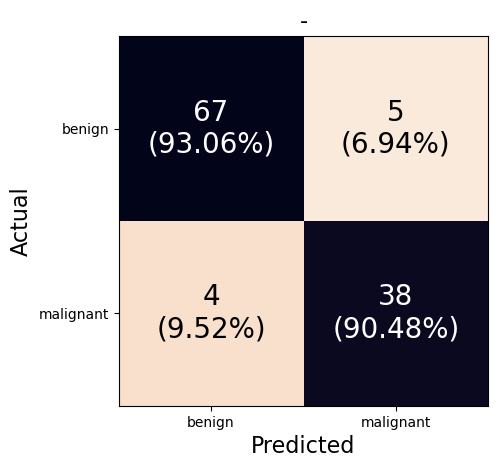

---------------------------------------
AUC validate: 97.06%
AUC test: 96.96%


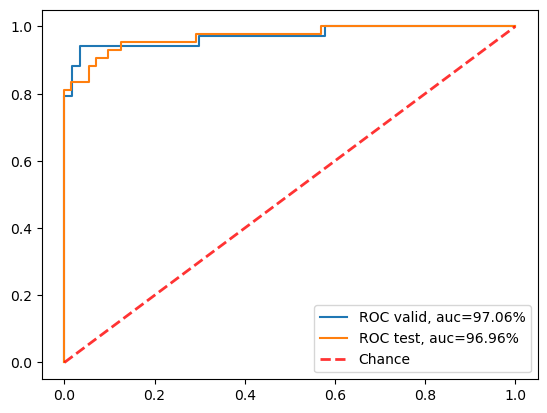

In [43]:
param = 4
param4_split3_cm_val, param4_split3_cm_test, param4_split3_AUC_val, param4_split3_AUC_test = evaluate(param,split)

## param5 split3

############## validate set ################
Best Threshold=0.591462
FPR: 0.0351
TPR: 0.9412
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
28  903011         B         15.50      392.0          0.08365   
55  903554         B         17.72      446.2          0.10290   
81  846381         M         23.95      782.7          0.08401   
87  925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
28         0.10070         0.1810                 0.07252       1.067   
55         0.04783         0.1937                 0.06161       1.652   
81         0.09938         0.1847                 0.05338       1.078   
87         0.25500         0.2128                 0.07152       1.205   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
28    22.97       0.010380       0.09472      0.01219              0.012330   
55    22.22       0.008146       0.01843      0.0201

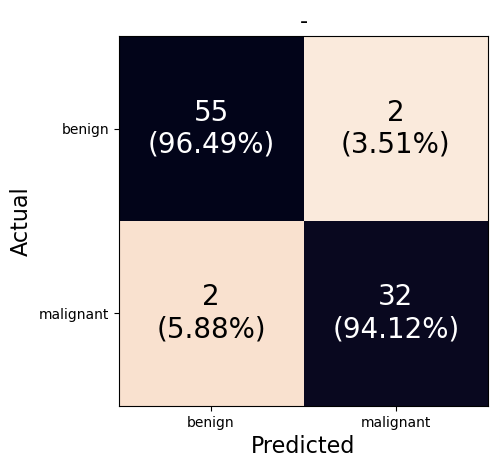

################# test set ##################
Best Threshold=0.557077
FPR: 0.0694
TPR: 0.9048
Confusion Matrix
----------------
[[67  5]
 [ 4 38]] 

----------------
split3
Sensitivity: 90.48%
Specificity: 93.06%
Accuracy: 92.11%
Precision: 88.37%
Sensitivity: 90.48%
Precision: 88.37%
F1: 89.41%


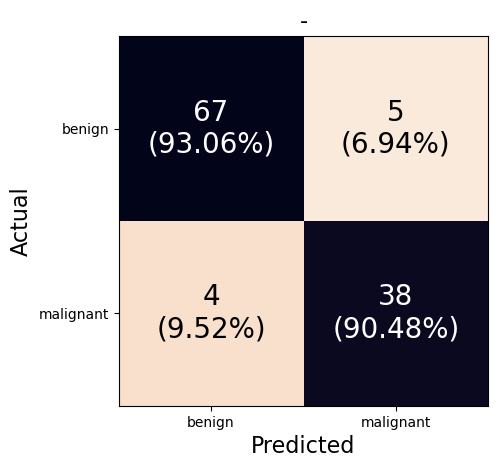

---------------------------------------
AUC validate: 97.06%
AUC test: 96.96%


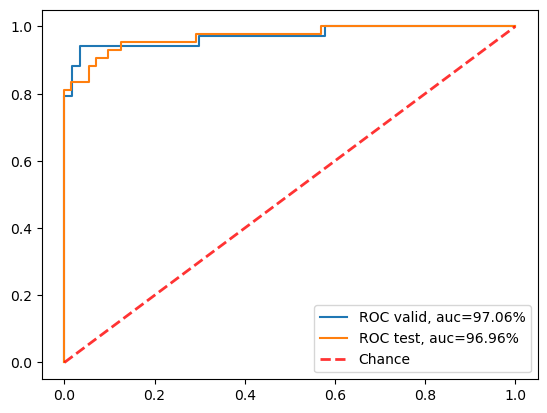

In [44]:
param = 5
param5_split3_cm_val, param5_split3_cm_test, param5_split3_AUC_val, param5_split3_AUC_test = evaluate(param,split)

# Setting Split 4

In [45]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split4

############## validate set ################
Best Threshold=0.623187
FPR: 0.0000
TPR: 0.9706
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
70  905539         B         21.68      268.8          0.07969   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
70         0.03735         0.1274                 0.06724       1.182   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
70    6.802       0.005515       0.03735      0.01951              0.004583   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
70            0.1086           0.1868          0.2376                  0.09206  
[70]
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


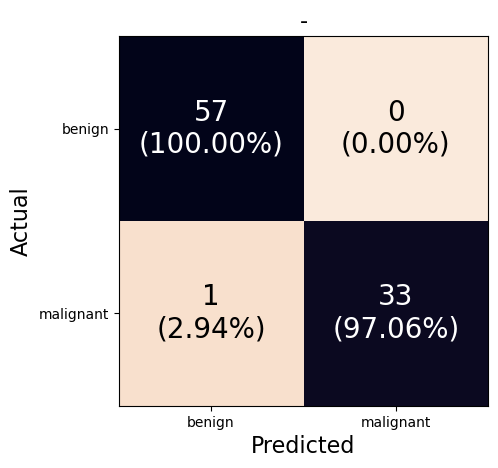

################# test set ##################
Best Threshold=0.319654
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


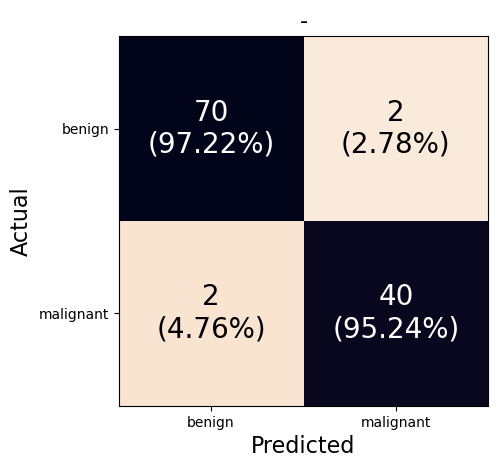

---------------------------------------
AUC validate: 99.28%
AUC test: 97.72%


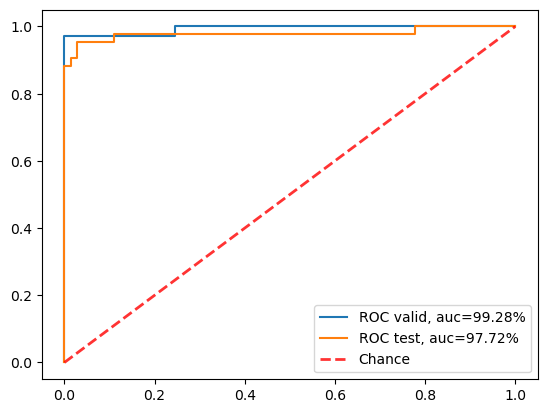

In [46]:
param = 1
param1_split4_cm_val, param1_split4_cm_test, param1_split4_AUC_val, param1_split4_AUC_test = evaluate(param,split)

## param2 split4

############## validate set ################
Best Threshold=0.623187
FPR: 0.0000
TPR: 0.9706
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
70  905539         B         21.68      268.8          0.07969   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
70         0.03735         0.1274                 0.06724       1.182   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
70    6.802       0.005515       0.03735      0.01951              0.004583   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
70            0.1086           0.1868          0.2376                  0.09206  
[70]
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


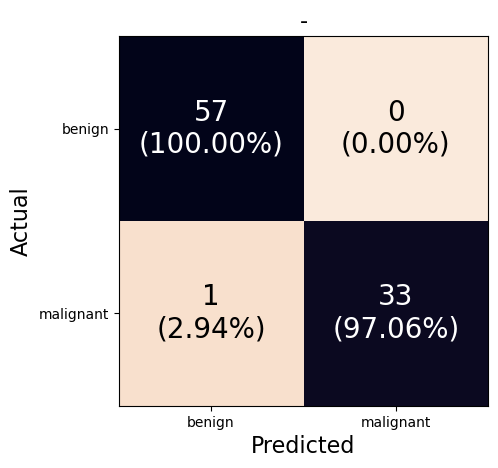

################# test set ##################
Best Threshold=0.319654
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


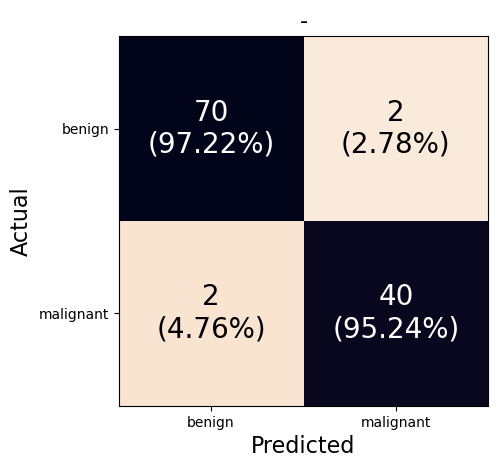

---------------------------------------
AUC validate: 99.28%
AUC test: 97.72%


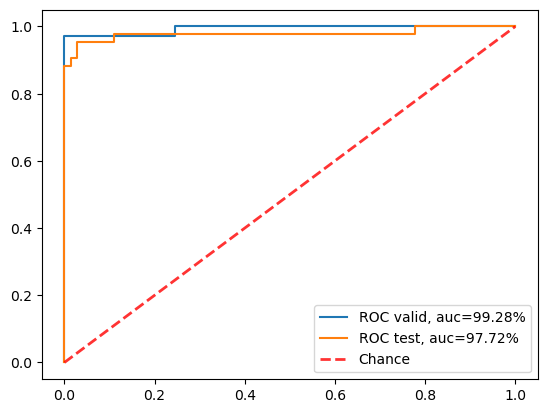

In [47]:
param = 2
param2_split4_cm_val, param2_split4_cm_test, param2_split4_AUC_val, param2_split4_AUC_test = evaluate(param,split)

## param3 split4

############## validate set ################
Best Threshold=0.623187
FPR: 0.0000
TPR: 0.9706
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
70  905539         B         21.68      268.8          0.07969   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
70         0.03735         0.1274                 0.06724       1.182   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
70    6.802       0.005515       0.03735      0.01951              0.004583   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
70            0.1086           0.1868          0.2376                  0.09206  
[70]
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


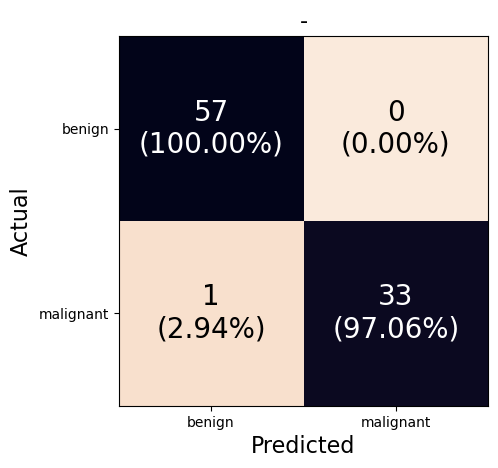

################# test set ##################
Best Threshold=0.319654
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


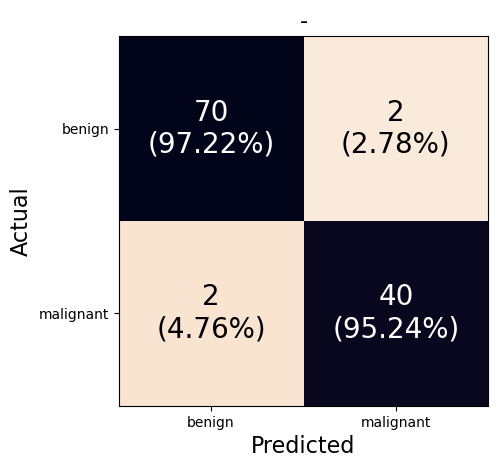

---------------------------------------
AUC validate: 99.28%
AUC test: 97.72%


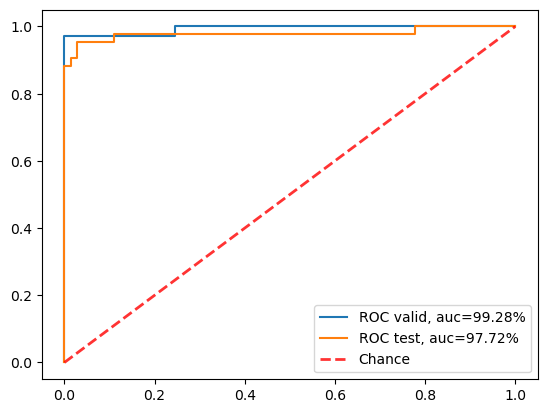

In [48]:
param = 3
param3_split4_cm_val, param3_split4_cm_test, param3_split4_AUC_val, param3_split4_AUC_test = evaluate(param,split)

## param4 split4

############## validate set ################
Best Threshold=0.623187
FPR: 0.0000
TPR: 0.9706
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
70  905539         B         21.68      268.8          0.07969   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
70         0.03735         0.1274                 0.06724       1.182   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
70    6.802       0.005515       0.03735      0.01951              0.004583   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
70            0.1086           0.1868          0.2376                  0.09206  
[70]
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


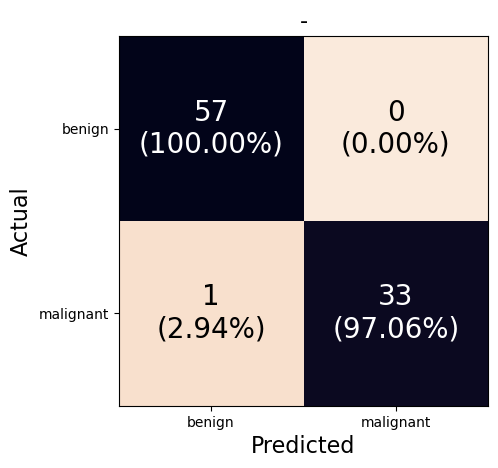

################# test set ##################
Best Threshold=0.319654
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


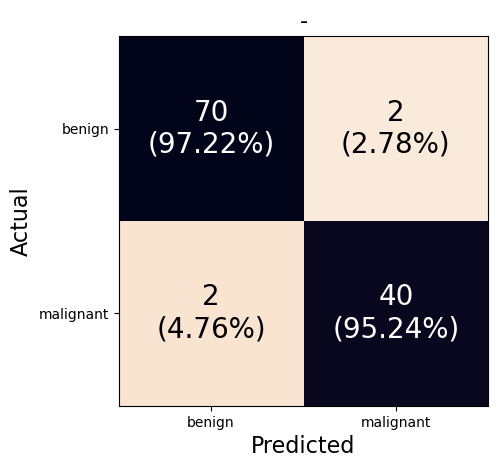

---------------------------------------
AUC validate: 99.28%
AUC test: 97.72%


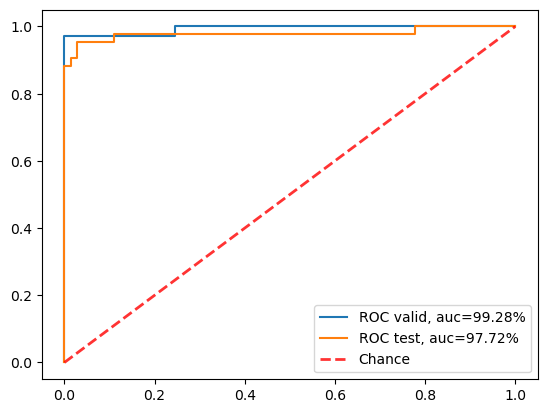

In [49]:
param = 4
param4_split4_cm_val, param4_split4_cm_test, param4_split4_AUC_val, param4_split4_AUC_test = evaluate(param,split)

## param5 split4

############## validate set ################
Best Threshold=0.623187
FPR: 0.0000
TPR: 0.9706
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
70  905539         B         21.68      268.8          0.07969   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
70         0.03735         0.1274                 0.06724       1.182   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
70    6.802       0.005515       0.03735      0.01951              0.004583   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
70            0.1086           0.1868          0.2376                  0.09206  
[70]
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


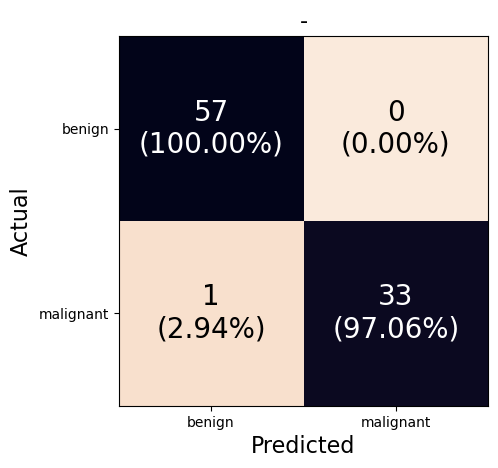

################# test set ##################
Best Threshold=0.319654
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


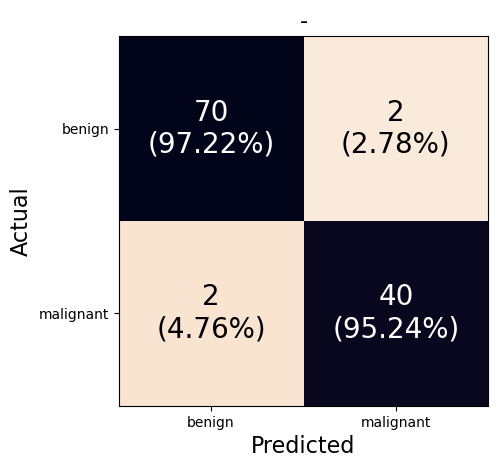

---------------------------------------
AUC validate: 99.28%
AUC test: 97.72%


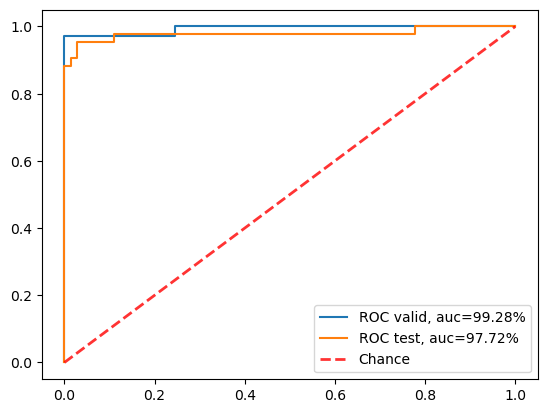

In [50]:
param = 5
param5_split4_cm_val, param5_split4_cm_test, param5_split4_AUC_val, param5_split4_AUC_test = evaluate(param,split)

# Setting Split 5

In [51]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split5

############## validate set ################
Best Threshold=0.398743
FPR: 0.0702
TPR: 0.9412
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
18   8712291         B         19.76      690.2          0.08421   
22    874158         B         15.11      317.5          0.09267   
43  88518501         B         18.45      407.4          0.09345   
44    911366         B         18.18      408.8          0.11750   
79    867739         M         21.91     1075.0          0.09430   
87    925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
18        0.019470         0.1515                 0.05266      1.0650   
22        0.001597         0.1703                 0.06048      1.2680   
43        0.026380         0.1834                 0.05934      0.8429   
44        0.102000         0.1957                 0.07255      1.7400   
79        0.115300         0.1692                 0.05727      1.

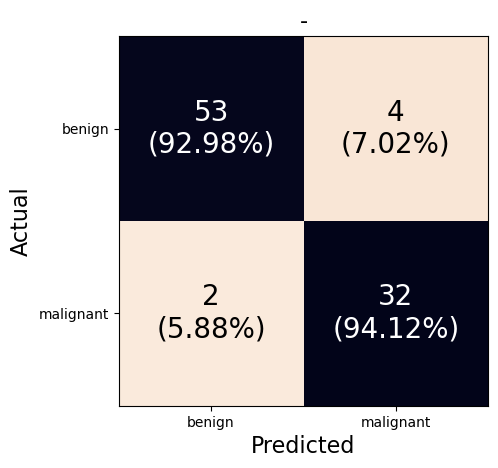

################# test set ##################
Best Threshold=0.328454
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


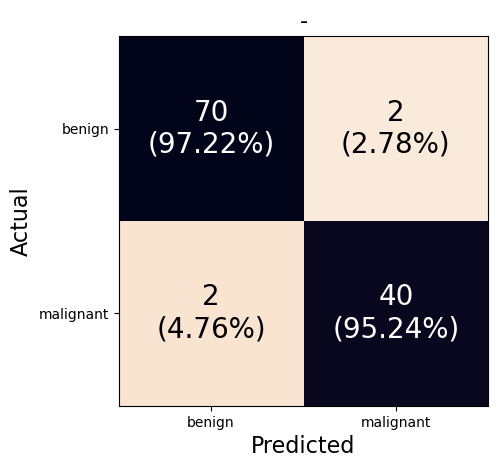

---------------------------------------
AUC validate: 97.47%
AUC test: 97.82%


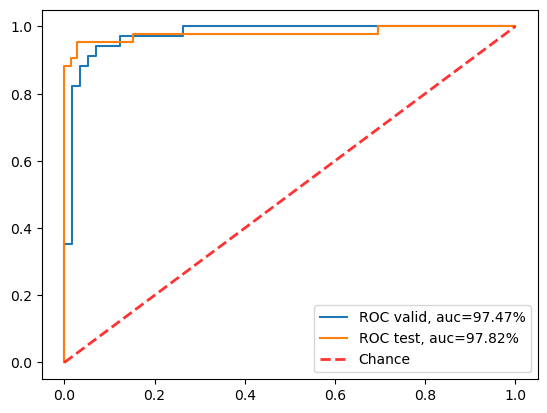

In [52]:
param = 1
param1_split5_cm_val, param1_split5_cm_test, param1_split5_AUC_val, param1_split5_AUC_test = evaluate(param,split)

## param2 split5

############## validate set ################
Best Threshold=0.398743
FPR: 0.0702
TPR: 0.9412
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
18   8712291         B         19.76      690.2          0.08421   
22    874158         B         15.11      317.5          0.09267   
43  88518501         B         18.45      407.4          0.09345   
44    911366         B         18.18      408.8          0.11750   
79    867739         M         21.91     1075.0          0.09430   
87    925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
18        0.019470         0.1515                 0.05266      1.0650   
22        0.001597         0.1703                 0.06048      1.2680   
43        0.026380         0.1834                 0.05934      0.8429   
44        0.102000         0.1957                 0.07255      1.7400   
79        0.115300         0.1692                 0.05727      1.

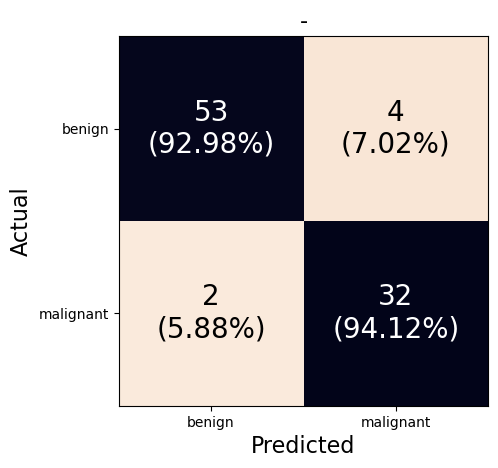

################# test set ##################
Best Threshold=0.328454
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


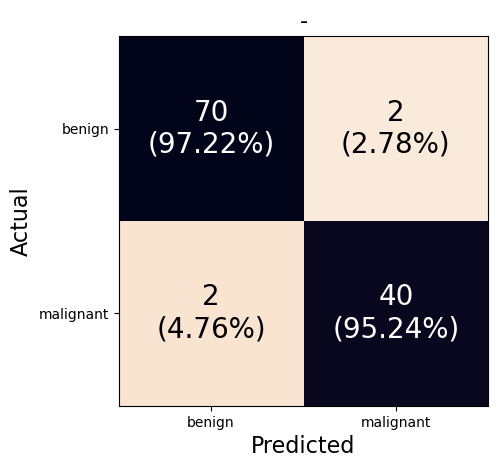

---------------------------------------
AUC validate: 97.47%
AUC test: 97.82%


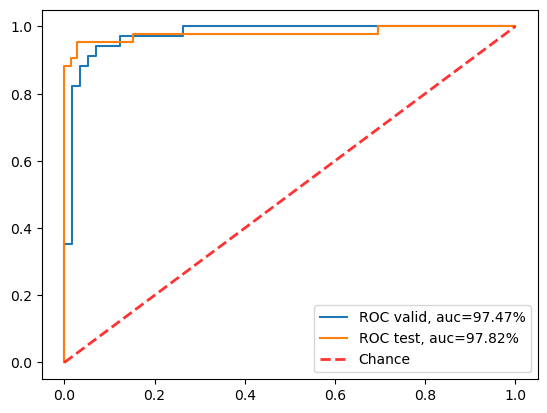

In [53]:
param = 2
param2_split5_cm_val, param2_split5_cm_test, param2_split5_AUC_val, param2_split5_AUC_test = evaluate(param,split)

## param3 split5

############## validate set ################
Best Threshold=0.398743
FPR: 0.0702
TPR: 0.9412
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
18   8712291         B         19.76      690.2          0.08421   
22    874158         B         15.11      317.5          0.09267   
43  88518501         B         18.45      407.4          0.09345   
44    911366         B         18.18      408.8          0.11750   
79    867739         M         21.91     1075.0          0.09430   
87    925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
18        0.019470         0.1515                 0.05266      1.0650   
22        0.001597         0.1703                 0.06048      1.2680   
43        0.026380         0.1834                 0.05934      0.8429   
44        0.102000         0.1957                 0.07255      1.7400   
79        0.115300         0.1692                 0.05727      1.

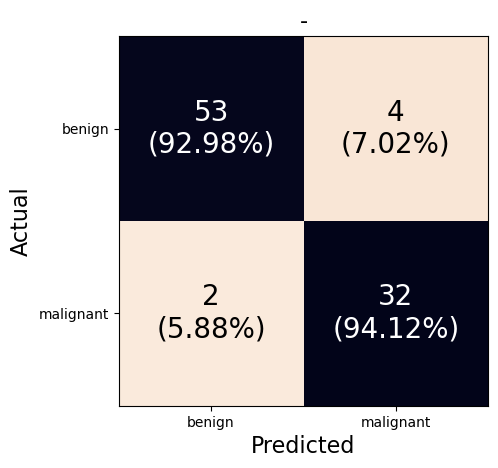

################# test set ##################
Best Threshold=0.328454
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


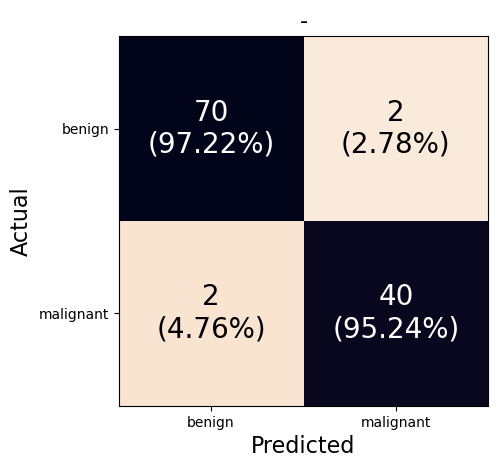

---------------------------------------
AUC validate: 97.47%
AUC test: 97.82%


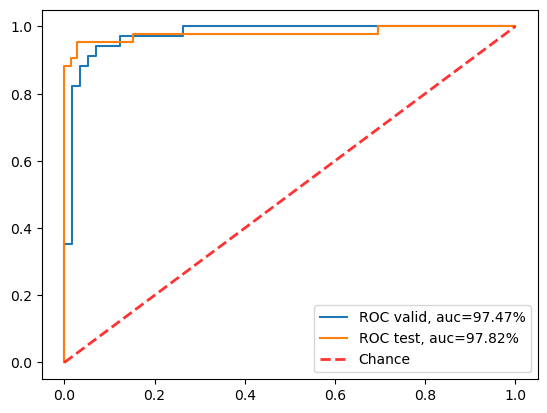

In [54]:
param = 3
param3_split5_cm_val, param3_split5_cm_test, param3_split5_AUC_val, param3_split5_AUC_test = evaluate(param,split)

## param4 split5

############## validate set ################
Best Threshold=0.398743
FPR: 0.0702
TPR: 0.9412
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
18   8712291         B         19.76      690.2          0.08421   
22    874158         B         15.11      317.5          0.09267   
43  88518501         B         18.45      407.4          0.09345   
44    911366         B         18.18      408.8          0.11750   
79    867739         M         21.91     1075.0          0.09430   
87    925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
18        0.019470         0.1515                 0.05266      1.0650   
22        0.001597         0.1703                 0.06048      1.2680   
43        0.026380         0.1834                 0.05934      0.8429   
44        0.102000         0.1957                 0.07255      1.7400   
79        0.115300         0.1692                 0.05727      1.

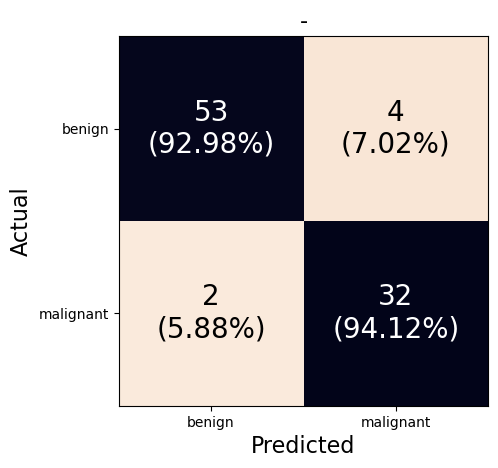

################# test set ##################
Best Threshold=0.328454
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


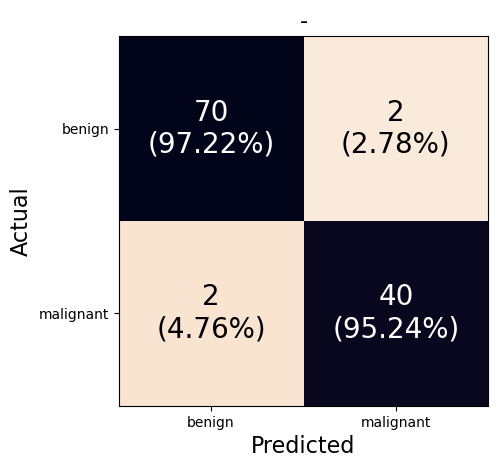

---------------------------------------
AUC validate: 97.47%
AUC test: 97.82%


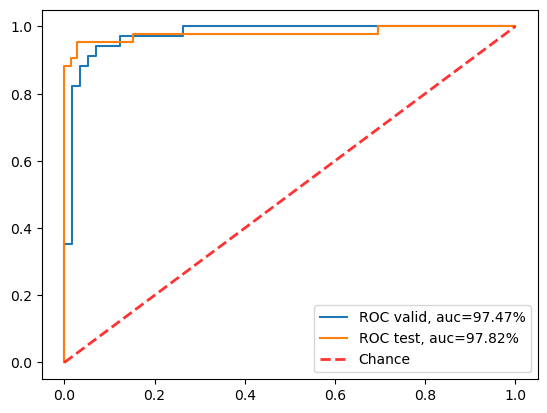

In [55]:
param = 4
param4_split5_cm_val, param4_split5_cm_test, param4_split5_AUC_val, param4_split5_AUC_test = evaluate(param,split)

## param5 split5

############## validate set ################
Best Threshold=0.398743
FPR: 0.0702
TPR: 0.9412
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
18   8712291         B         19.76      690.2          0.08421   
22    874158         B         15.11      317.5          0.09267   
43  88518501         B         18.45      407.4          0.09345   
44    911366         B         18.18      408.8          0.11750   
79    867739         M         21.91     1075.0          0.09430   
87    925622         M         30.62      716.9          0.10480   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
18        0.019470         0.1515                 0.05266      1.0650   
22        0.001597         0.1703                 0.06048      1.2680   
43        0.026380         0.1834                 0.05934      0.8429   
44        0.102000         0.1957                 0.07255      1.7400   
79        0.115300         0.1692                 0.05727      1.

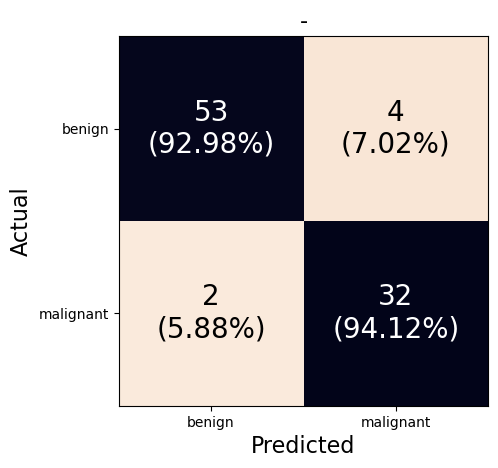

################# test set ##################
Best Threshold=0.328454
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


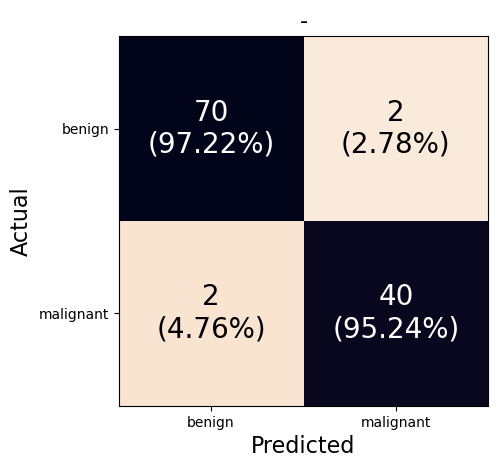

---------------------------------------
AUC validate: 97.47%
AUC test: 97.82%


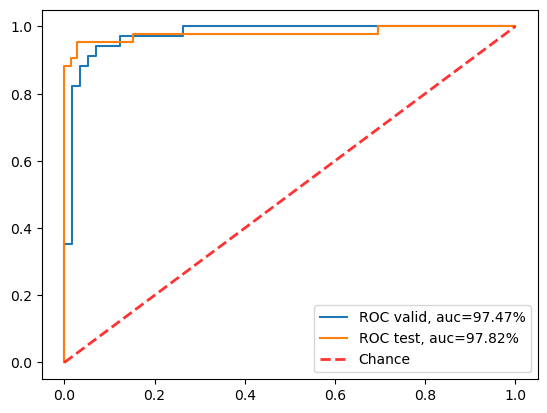

In [ ]:
param = 5
param5_split5_cm_val, param5_split5_cm_test, param5_split5_AUC_val, param5_split5_AUC_test = evaluate(param,split)

# overall

In [43]:
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))

In [44]:
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black")
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()

## overall param1

param1
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%

split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split5
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

overall
sensitivity: 98.24 ± 1.61%
specificity: 98.25 ± 1.75%
accuracy: 98.24 ± 0.98%
precision: 97.17 ± 2.82%
f1_score: 97.67 ± 1.28%


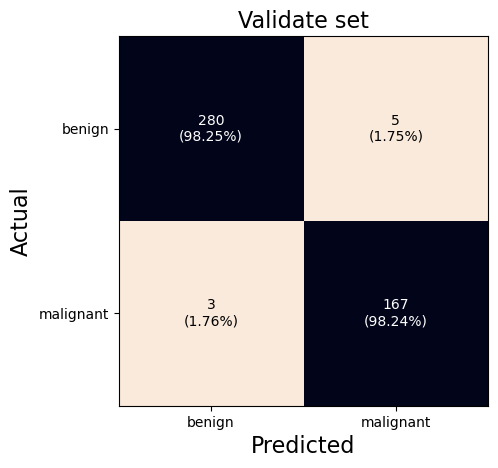

AUC1: 9976.26 ± 17.35%


In [45]:
print("param1")
plot(param1_split1_cm_val , param1_split2_cm_val , param1_split3_cm_val , param1_split4_cm_val , param1_split5_cm_val)
Mean_SD("AUC1",param1_split1_AUC_val*100, param1_split2_AUC_val*100, param1_split3_AUC_val*100, param1_split4_AUC_val*100, param1_split5_AUC_val*100)

## overall param2

param2
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%

split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split5
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

overall
sensitivity: 98.24 ± 1.61%
specificity: 98.25 ± 1.75%
accuracy: 98.24 ± 0.98%
precision: 97.17 ± 2.82%
f1_score: 97.67 ± 1.28%


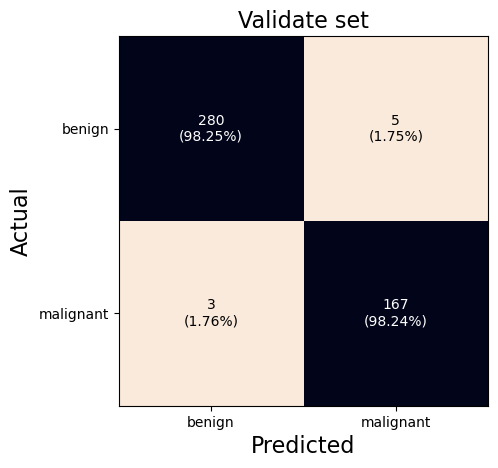

AUC2: 9976.26 ± 17.35%


In [46]:
print("param2")
plot(param2_split1_cm_val , param2_split2_cm_val , param2_split3_cm_val , param2_split4_cm_val , param2_split5_cm_val)
Mean_SD("AUC2",param2_split1_AUC_val*100, param2_split2_AUC_val*100, param2_split3_AUC_val*100, param2_split4_AUC_val*100, param2_split5_AUC_val*100)

## overall param3

param3
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%

split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split5
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

overall
sensitivity: 98.24 ± 1.61%
specificity: 98.25 ± 1.75%
accuracy: 98.24 ± 0.98%
precision: 97.17 ± 2.82%
f1_score: 97.67 ± 1.28%


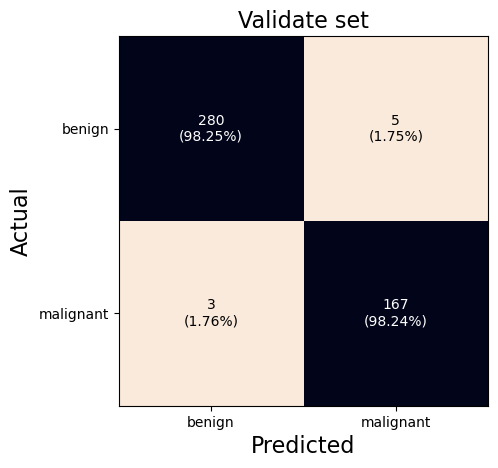

AUC3: 9976.26 ± 17.35%


In [47]:
print("param3")
plot(param3_split1_cm_val , param3_split2_cm_val , param3_split3_cm_val , param3_split4_cm_val , param3_split5_cm_val)
Mean_SD("AUC3",param3_split1_AUC_val*100, param3_split2_AUC_val*100, param3_split3_AUC_val*100, param3_split4_AUC_val*100, param3_split5_AUC_val*100)

## overall param4

param4
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%

split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split5
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

overall
sensitivity: 98.24 ± 1.61%
specificity: 98.25 ± 1.75%
accuracy: 98.24 ± 0.98%
precision: 97.17 ± 2.82%
f1_score: 97.67 ± 1.28%


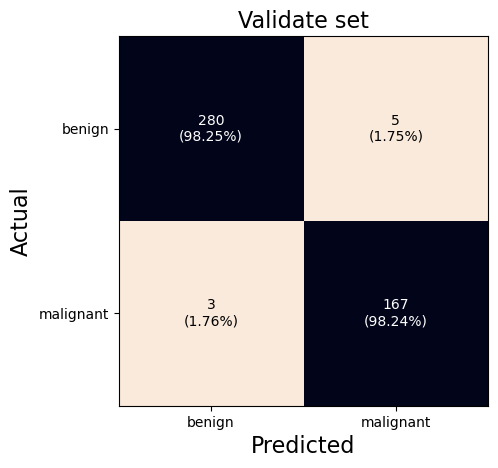

AUC4: 9976.26 ± 17.35%


In [48]:
print("param4")
plot(param4_split1_cm_val , param4_split2_cm_val , param4_split3_cm_val , param4_split4_cm_val , param4_split5_cm_val)
Mean_SD("AUC4",param4_split1_AUC_val*100, param4_split2_AUC_val*100, param4_split3_AUC_val*100, param4_split4_AUC_val*100, param4_split5_AUC_val*100)

## overall param5

param5
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%

split4
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split5
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

overall
sensitivity: 98.24 ± 1.61%
specificity: 98.25 ± 1.75%
accuracy: 98.24 ± 0.98%
precision: 97.17 ± 2.82%
f1_score: 97.67 ± 1.28%


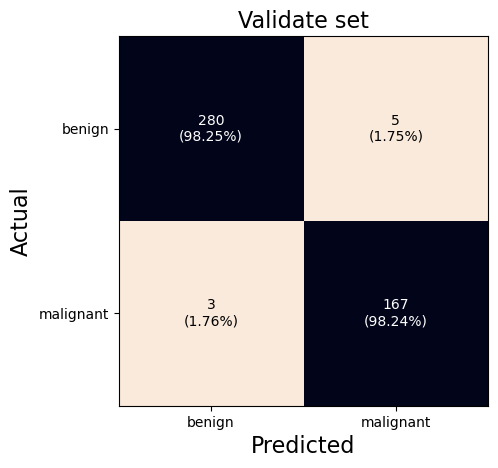

AUC5: 9976.26 ± 17.35%


In [49]:
print("param5")
plot(param5_split1_cm_val , param5_split2_cm_val , param5_split3_cm_val , param5_split4_cm_val , param5_split5_cm_val)
Mean_SD("AUC5",param5_split1_AUC_val*100, param5_split2_AUC_val*100, param5_split3_AUC_val*100, param5_split4_AUC_val*100, param5_split5_AUC_val*100)

# Final test

In [50]:
# setting split and path final test
path = "../Anny_oversampling/DATA/"
train_path = "{}/train.csv".format(path)
test_path =  "{}/test.csv".format(path)
print(train_path)
# Load the train set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)
print(test_path)
# Load the test set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[3:]]
print(x_test.shape)
y_test = test_data[test_data.columns[2]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)
# StandardScaler
sc = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

svm = SVC(C=10, gamma=0.01, kernel='rbf')
lr = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')
dt = DecisionTreeClassifier(criterion="gini", max_depth=4, min_samples_leaf=3, min_samples_split=7, splitter="random")
sgd = SGDClassifier(loss='hinge', penalty='elasticnet', learning_rate='optimal', eta0=0.001, max_iter=1000, alpha=0.01)
rf = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=6, max_features='sqrt', min_samples_leaf=3, min_samples_split=7, n_estimators=120)
ensemble = VotingClassifier(estimators=[('svm', svm), ('lr', lr), ('dt', dt), ('sgd', sgd), ('rf', rf)], voting='hard')
ensemble.fit(x_train, y_train)
joblib.dump(ensemble, 'ensemble_model_Final/ensemble_Final_model.joblib')

../Anny_oversampling/DATA//train.csv
(455, 32)
(455, 30)
['B' 'M']
../Anny_oversampling/DATA//test.csv
(114, 33)
(114, 30)
['B' 'M']


FileNotFoundError: [Errno 2] No such file or directory: 'ensemble_model_Final/ensemble_Final_model.joblib'

In [ ]:
loaded_model = joblib.load('../temp/ensemble_model_Final/ensemble_Final_model.joblib')
# ################# test set ##################
label = ['benign','malignant']
print("################# test set ##################")
y_pred_test = loaded_model.predict(x_test)
# Print the predictions
# print(y_pred)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
print(split)
sen_test = sensitivity(cm_test)
spec_test = specificity(cm_test)
acc_test = accuracy(cm_test)
pre_test = precision(cm_test)
f1_score_test = f1(cm_test)

# plot confusion matrix
# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_test.shape[1]),
       yticks=np.arange(cm_norm_test.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_test.max() / 2.
for i in range(cm_norm_test.shape[0]):
    for j in range(cm_norm_test.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_test[i, j] > thresh else "black")

plt.show()

################## plot ROC curve ########################
# fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
# auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
# print("AUC validate: %.4f" % auc1)
print("AUC test: %.4f" % auc2)
# plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.legend(loc=4)
plt.show()

# Font size

In [ ]:
############## validate set ################
split = "split1"
loaded_model = joblib.load('SVM_model-ROC/SVM_{}.joblib'.format(split))
print("############## validate set ################")
y_pred_val = loaded_model.predict_proba(x_val)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
print('Confusion Matrix')
print('-'*16)
print(cm_val,'\n')
print('-'*16)

# Calculate score
print(split)
sen_val = sensitivity(cm_val)
spec_val = specificity(cm_val)
acc_val = accuracy(cm_val)
pre_val = precision(cm_val)
f1_score_val = f1(cm_val)

class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# Create plot with larger size
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Validate set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
        
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black",
               fontsize=24)
plt.show()

# threshold

In [ ]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

In [ ]:
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [ ]:
def ROC_split(split1,split2,split3,split4,split5):
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)*100
    
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr3, tpr3, thr3 = metrics.roc_curve(y_test,  y_pred_test)
    auc3 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr4, tpr4, thr4 = metrics.roc_curve(y_test,  y_pred_test)
    auc4 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr5, tpr5, thr5 = metrics.roc_curve(y_test,  y_pred_test)
    auc5 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    # gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    # ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC split1: %.2f%%" % auc1)
    print("AUC split2: %.2f%%" % auc2)
    print("AUC split3: %.2f%%" % auc1)
    print("AUC split4: %.2f%%" % auc2)
    print("AUC split5: %.2f%%" % auc1)
    
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc3))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc4))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [ ]:
param = 3
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

In [ ]:
param = 1
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate_no_prob(param,split)

In [ ]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
param = 1
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)